The function of this notebook is to load, clean and embed the dataframe to be used in the final model. The dataframe is then saved in a .csv file, which can be loaded in the final program. This achieves optimization in the final program and website deployment. 

In [2]:
from pathlib import Path
import kagglehub
import pandas as pd
import os
import pickle
from pathlib import Path
import joblib
import re
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from dotenv import load_dotenv
import openai
from datetime import datetime


In [10]:
# Import libraries
# Import all necessary libraries for this program



# Download dataset
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

# Read CSV files
file_path1 = os.path.join(path, "1429_1.csv")
file_path2 = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
file_path3 = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

# Load pickle mapping

pickle_file_path = Path.cwd() / "Joblib_files" / "unique_categories_dict.pkl"
if not pickle_file_path.exists():
    raise FileNotFoundError(f"Missing pickle file: {pickle_file_path}")
with open(pickle_file_path, "rb") as f:
    meta_category_mapping = pickle.load(f)

# Filter and prepare data
columns_df1 = ['name', 'asins', 'categories', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title']
columns_other = columns_df1 + ['imageURLs']
df1_filtered = df1[columns_df1]
df1_filtered['imageURLs'] = "https://upload.wikimedia.org/wikipedia/commons/a/ac/No_image_available.svg"
df2_filtered = df2[columns_other]
df3_filtered = df3[columns_other]

# Combine the dataframes, and map the meta-categories that we extracted via the clustering model to the 'categories' column
df_combined = pd.concat([df1_filtered, df2_filtered, df3_filtered], ignore_index=True)
df_combined['meta_category'] = df_combined['categories'].map(meta_category_mapping).fillna("Unknown")

# Print output of the combined dataframe
print("Shape of the combined dataframe:", df_combined.shape)
print(df_combined.head())


# First we need to clean the data with our data cleaning function, taking into account that the reviews.text column is a string but might contain floats
# Clean the review text column and append the cleaned text to a new column, given the size of the dataset this will not increase the model runtime significantly
def light_clean(text):
    if isinstance(text, float):
        text = str(text)  # Convert float to string
    text = text.strip()
    text = re.sub(r"\s+", " ", text)  # normalize whitespace
    return text

df_combined["cleaned_text"] = df_combined["reviews.text"].apply(light_clean)

# Then we convert the relevant columns of the dataframe to word embeddings using a pre-trained sentence transformer model. We use a sentence transformer as these are designed 
# to work well with natural, unaltered sentences and are trained on a large corpus of text data, making them suitable for generating embeddings for a wide range of text inputs.

model = SentenceTransformer('all-MiniLM-L6-v2')
# Generate embeddings for the cleaned review text
embeddings = model.encode(df_combined["cleaned_text"].tolist(), show_progress_bar=True, convert_to_tensor= True, device='cuda')
# Append the embeddings to the dataframe
df_combined["embeddings"] = embeddings.tolist()

Shape of the combined dataframe: (67992, 10)
                                                name       asins  \
0  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2   
1  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2   
2  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2   
3  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2   
4  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...  B01AHB9CN2   

                                          categories reviews.doRecommend  \
0  Electronics,iPad & Tablets,All Tablets,Fire Ta...                True   
1  Electronics,iPad & Tablets,All Tablets,Fire Ta...                True   
2  Electronics,iPad & Tablets,All Tablets,Fire Ta...                True   
3  Electronics,iPad & Tablets,All Tablets,Fire Ta...                True   
4  Electronics,iPad & Tablets,All Tablets,Fire Ta...                True   

   reviews.numHelpful  reviews.rating  \
0                 0.0             5.0   
1      

Batches:   0%|          | 0/2125 [00:00<?, ?it/s]

In [11]:
# Save the combined dataframe with embeddings to a CSV file
output_file_path = Path.cwd() / "Joblib_files" / "amazon_reviews_with_embeddings.csv"
df_combined.to_csv(output_file_path, index=False)

In [15]:
load_dotenv()  # Load environment variables from .env file

# Use the standard environment variable name for OpenAI API key
api_key = os.getenv("OPENAI_TEST_KEY_KdR")
if not api_key:
    raise ValueError("OpenAI API key not found. Please set the OPENAI_TEST_KEY_KdR environment variable.")

client = openai.OpenAI(api_key=api_key)

# Print the OpenAI API key to confirm it is loaded correctly (for debugging, remove in production)
print("OpenAI API key loaded successfully.")

OpenAI API key loaded successfully.


In [14]:
# Combine all the dataframes that contain the final model output into a single dataframe, that can be loaded into the website
files_to_load = ["Batteries_Summary.csv", "Connected_Home_Electronics.csv", "Kitchen_Storage_Summary.csv", 
                  "Office_Supplies_Summary.csv", "Pet_Products_Summary.csv", "Portable_Electronics.csv"]

# Load each file to load and concatenate them into a single dataframe
dataframes = []
for file_name in files_to_load:
    file_path = Path.cwd() / "Product Summaries" / file_name
    if not file_path.exists():
        print(f"File {file_name} does not exist, skipping.")
        continue
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
Summaries_df = pd.concat(dataframes, ignore_index=True)
# Save the combined dataframe to a CSV file
output_summaries_path = Path.cwd() / "Product Summaries" / "Summaries Combined.csv"
Summaries_df.to_csv(output_summaries_path, index=False)



In [24]:
from rouge import Rouge
import pandas as pd
from tqdm import tqdm
import numpy as np

# Normalize column names
df_combined = df_combined.rename(columns={
    'meta-category': 'category',  # fix this if needed
    'meta_category': 'category',
    'reviews.text': 'reviews_text',
    'reviews_text': 'reviews_text'  # handles both cases safely
})

# Drop rows with missing reference reviews
df_combined = df_combined.dropna(subset=['reviews_text'])
Summaries_df = Summaries_df.rename(columns={'category': 'category'})  # make sure it's named 'category'
Summaries_df = Summaries_df.reset_index(drop=True)

# Initialize ROUGE
rouge = Rouge()
rouge_scores = []

# Loop through summaries and match by category
for i in tqdm(range(len(Summaries_df)), desc="Calculating ROUGE scores by category"):
    summary = Summaries_df.loc[i, 'summary']
    category = Summaries_df.loc[i, 'category']
    
    # Filter for same-category reference reviews
    candidate_refs = df_combined[df_combined['category'] == category]['reviews_text'].dropna()
    
    if candidate_refs.empty or pd.isna(summary) or not summary.strip():
        rouge_scores.append(None)
        continue

    # Sample one reference review from the same category
    reference = candidate_refs.sample(n=1, random_state=np.random.randint(0, 10000)).values[0]

    try:
        scores = rouge.get_scores(summary, reference)
        rouge_scores.append(scores[0])
    except Exception as e:
        print(f"Error at index {i}: {e}")
        rouge_scores.append(None)

# Format and attach
rouge_df = pd.DataFrame(rouge_scores)
Summaries_df[['rouge-1', 'rouge-2', 'rouge-l']] = rouge_df[['rouge-1', 'rouge-2', 'rouge-l']]

# Sample output
print(Summaries_df[['category', 'summary', 'rouge-1', 'rouge-2', 'rouge-l']].head())


Calculating ROUGE scores by category: 100%|██████████| 16/16 [00:00<00:00, 134.97it/s]

                     category  \
0                   Batteries   
1                   Batteries   
2  Connected Home Electronics   
3  Connected Home Electronics   
4  Connected Home Electronics   

                                             summary  \
0  Customers generally find AmazonBasics AAA Perf...   
1  The AmazonBasics AA Performance Alkaline Batte...   
2  The Amazon Echo Plus with Built-In Hub in Silv...   
3  The Amazon Echo Show receives high praise for ...   
4  The Echo (White) has received very positive re...   

                                             rouge-1  \
0  {'r': 0.1951219512195122, 'p': 0.1379310344827...   
1                     {'r': 0.0, 'p': 0.0, 'f': 0.0}   
2  {'r': 0.18181818181818182, 'p': 0.032786885245...   
3  {'r': 0.14545454545454545, 'p': 0.140350877192...   
4  {'r': 0.2727272727272727, 'p': 0.0517241379310...   

                                             rouge-2  \
0  {'r': 0.02127659574468085, 'p': 0.015151515151...   
1              

TypeError: unhashable type: 'dict'

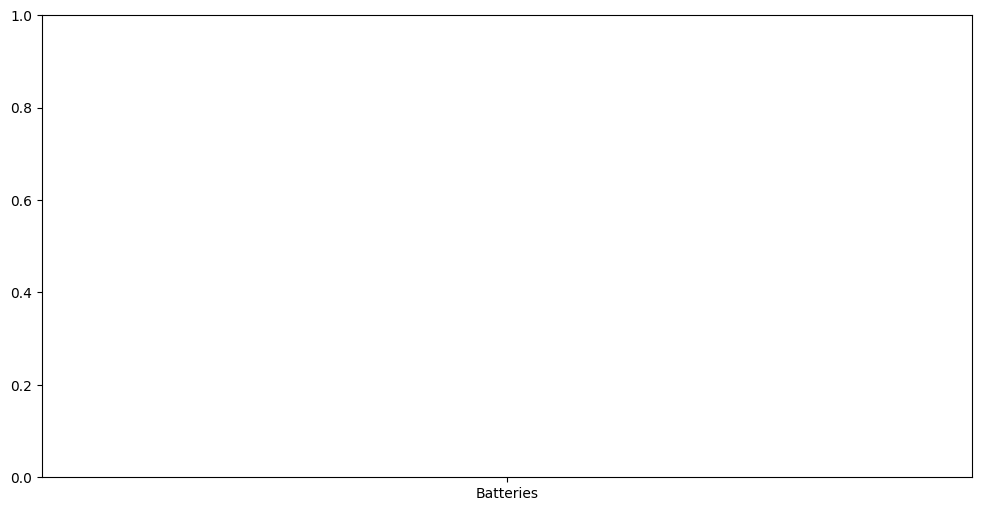

In [25]:
# Visualize the ROUGE scores
import matplotlib.pyplot as plt
# Plotting ROUGE scores
def plot_rouge_scores(df, score_type):
    plt.figure(figsize=(12, 6))
    plt.bar(df['category'], df[score_type], color='skyblue')
    plt.xlabel('Category')
    plt.ylabel(score_type)
    plt.title(f'ROUGE {score_type} Scores by Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
# Plot each ROUGE score
plot_rouge_scores(Summaries_df, 'rouge-1')
plot_rouge_scores(Summaries_df, 'rouge-2')
